In [1]:
from pathlib import Path
import yaml
%load_ext autoreload
%autoreload 2

current_dir = Path().resolve() 
parent_dir = current_dir.parent    
results_dir = parent_dir / "results"

In [16]:
from abcnre.simulation.models import GaussGaussMultiDimModel
from abcnre.simulation.samplers import SummarizedStatisticalModel, RejectionSampler
from abcnre.simulation.utils import get_epsilon_quantile, get_io_generator, create_summary_stats_fn

from abcnre.training import get_nn_config

import jax
import jax.numpy as jnp
from jax import random

from typing import Callable, Tuple, Any, Dict, Optional, Union

import matplotlib.pyplot as plt

key = jax.random.PRNGKey(123)

def comp_plot(x, y, ax=None):
    if ax:
        ax.plot(x, y, 'b.')
        ax.plot(x, x, 'k-')
    else:
        plt.plot(x, y, 'b.')
        plt.plot(x, x, 'k-')

In [3]:
# Set up a model to generate draws from the first component of a 2d Gaussian

model = GaussGaussMultiDimModel(mu0=0., sigma0=1.0, sigma=2.0, dim=2, n_obs=5)
model0 = SummarizedStatisticalModel(model, lambda theta: jnp.array([ theta[0] ]))
key, _key = jax.random.split(key, 2)
phi_draws, x_draws = model0.sample_theta_x_multiple(_key, 5)
phi_draws

Array([[-1.4444284 ],
       [ 1.7635945 ],
       [-1.4011569 ],
       [ 0.23181824],
       [ 1.5486579 ]], dtype=float32)

In [4]:
nn_config = get_nn_config(network_name="deepset",
                          network_size = "default",
                          training_size = "default",
                          task_type = "regressor",
                          lr_scheduler_name = "reduce_on_plateau",
                          lr_scheduler_variant = "default",
                          stopping_rules_variant = "balanced",
                          experiment_name = None)

In [5]:
print(hasattr(nn_config.training, "stopping_rules"))
print(isinstance(nn_config.training.stopping_rules, dict))
print(hasattr(nn_config.training.stopping_rules, "sample_stopping"))

True
True
False


In [6]:
# RG: Why is it even possible for it to be both StoppingRulesConfig or Dict?
n_samples_max = jnp.inf
if isinstance(nn_config.training.stopping_rules, dict):
    # Working with dictionary format - need to modify it
    if "sample_stopping" not in nn_config.training.stopping_rules:
        nn_config.training.stopping_rules["sample_stopping"] = {}

    nn_config.training.stopping_rules["sample_stopping"]["enabled"] = True
    nn_config.training.stopping_rules["sample_stopping"][
        "max_samples"
    ] = n_samples_max
elif hasattr(nn_config.training.stopping_rules, "sample_stopping"):
    # Working with StoppingRulesConfig object
    nn_config.training.stopping_rules.sample_stopping.enabled = True
    nn_config.training.stopping_rules.sample_stopping.max_samples = (
        n_samples_max
    )

In [7]:
io_generator = get_io_generator(model0.sample_theta_x_multiple)
io_generator(key, 2)

{'input': Array([[[-1.4092901 ,  0.35230592],
         [-1.99227   , -0.6037842 ],
         [-1.5806706 ,  2.8814423 ],
         [-0.40986162, -1.5043074 ],
         [-0.59669155, -1.0447356 ]],
 
        [[ 0.08437496, -0.43321306],
         [-0.92502487, -0.26413488],
         [ 1.194182  , -1.5840983 ],
         [-0.22363687,  0.03412068],
         [-1.6675947 , -0.02828574]]], dtype=float32),
 'output': Array([[-0.37115902],
        [-0.7742927 ]], dtype=float32),
 'n_simulations': 2}

In [8]:
# Train a nn
from abcnre.training import train_nn
key, train_key = random.split(key)
summary_results = train_nn(key=train_key, config=nn_config, io_generator=io_generator)

In [9]:
summary_fn = create_summary_stats_fn(
    network=summary_results.network,
    params=summary_results.params)

In [10]:
key, key_ = random.split(key)
phi_draws, x_draws = model0.sample_theta_x_multiple(key_, n_samples=1000)

In [11]:
x_draws.shape
x_means = jnp.mean(x_draws[:, :, 0], axis=1) # The correct summary statistic
x_nn_means = summary_fn(x_draws)

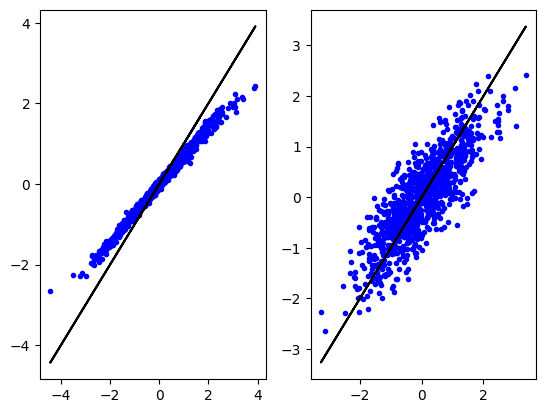

In [17]:
_, axs = plt.subplots(1, 2)
comp_plot(x_means, x_nn_means, axs[0])
comp_plot(phi_draws, x_nn_means, axs[1])

In [ ]:
print("--- Step 2.1: Sample x_obs and initialize the ABCSimulator ---")

true_theta = 2.5
key, subkey_sample = jax.random.split(key)
x_obs = simulator.model.simulate_data(subkey_sample, true_theta)

simulator.update_observed_data(x_obs)
print(f"Observation x_obs: {x_obs}")

quantile_distance = 1.
key, subkey_epsilon = jax.random.split(key)
simulator.set_epsilon_from_quantile(key = subkey_epsilon, quantile_distance=quantile_distance, n_samples=10000)

In [ ]:
print("--- Step 2.2: Save model to YAML (Optional) ---")

from abcnre.simulation import save_simulator_to_yaml


save_simulator_to_yaml(
    simulator,
    results_dir / "simulator" / "simulator.yaml",
    overwrite=True
)

In [ ]:
print("--- Step 2.3 : Load model from YAML and check (Optional) ---")

from abcnre.simulation import load_simulator_from_yaml
simulator_loaded = load_simulator_from_yaml(
    results_dir / "simulator" / "simulator.yaml",
)

key, key_samples, key_samples_load = jax.random.split(key, 3)
samples = simulator_loaded.generate_samples(key_samples, n_samples=100000)
samples_load = simulator_loaded.generate_samples(key_samples_load, n_samples=100000)

import seaborn as sns
import matplotlib.pyplot as plt
sns.kdeplot(samples.phi.flatten(), label="Samples from simulator"
            )
sns.kdeplot(samples_load.phi.flatten(), label="Samples from loaded simulator")
plt.legend()
plt.title("Phi marginal of the two simulators")
plt.xlabel("Phi samples")

In [ ]:
from abcnre.training import NNConfig, NetworkConfig, TrainingConfig, get_nn_config
print("--- Step 3.1: Create NNConfig for training ---")
nn_config = get_nn_config(network_name="mlp",
                          network_size = "default",
                          training_size = "default",
                          task_type = "classifier",
                          lr_scheduler_name = "reduce_on_plateau",
                          lr_scheduler_variant = "default",
                          stopping_rules_variant = "balanced",
                          experiment_name = None)


nn_config.training.num_epochs = 500
nn_config.training.batch_size = 1024
nn_config.training.n_samples_per_epoch = 10240
nn_config.training.learning_rate = 1e-2
nn_config.training.optimizer= "adamw"
nn_config.training.weight_decay = 1e-3

In [ ]:
print("--- Step 3.2: Create NeuralRatioEstimator ---")

from abcnre.inference import NeuralRatioEstimator    

estimator = NeuralRatioEstimator(
    nn_config=nn_config,
    simulator=simulator)

In [ ]:
print("--- Step 3.3: Train the NeuralRatioEstimator ---")

key, key_train = jax.random.split(key)
res = estimator.train(key_train, n_phi_to_store = 10000)

In [ ]:
print("--- Step 3.4: Save the NeuralRatioEstimator to YAML (Optional) ---")

from abcnre.inference.io import save_estimator_to_yaml
save_estimator_to_yaml(
    estimator,
    results_dir / "estimator" / "estimator.yaml",
    overwrite=True
)


In [ ]:
print("--- Step 3.5: Load the NeuralRatioEstimator from YAML and check (Optional) ---")

from abcnre.inference import load_estimator_from_yaml

estimator_loaded = load_estimator_from_yaml(
    results_dir / "estimator" / "estimator.yaml",
)

key, key_samples_estimator, key_samples_estimator_load = jax.random.split(key, 3)
samples_estimator = estimator.simulator.generate_samples(key_samples_estimator, n_samples=100000)
samples_estimator_load = estimator_loaded.simulator.generate_samples(key_samples_estimator_load, n_samples=100000)
import seaborn as sns
import matplotlib.pyplot as plt
sns.kdeplot(samples_estimator.phi.flatten(), label="Samples from estimator")
sns.kdeplot(samples_estimator_load.phi.flatten(), label="Samples from loaded estimator")
plt.legend()
plt.title("Phi marginal of the two estimators") 